In [1]:
# General Imports
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Statistical Imports
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull

# Seaborn settings
sns.set(rc={'figure.figsize':(16, 12)})
sns.set_style("darkgrid", {'axes.grid' : False})

# Final Assignment Simon Groß & Dominik Knabe
Analysing AirBNB Listings in Vienna and comparing it to POIs.

### Read Data
Three datasets are used: A csv-file with the AirBNB listings, a csv-file wih the POIs and a shapefile with viennas district boundaries.

In [2]:
listings = pd.read_csv(r".\data\listings.csv")
pois = pd.read_csv(r".\data\top-locations-wien.csv", sep=";",encoding="ISO-8859-1", decimal=',')
grenzen = gpd.read_file(r".\data\BEZIRKSGRENZEOGDPolygon.shp")

### Data Wrangling
First we have to convert the csv-files into GeoDataFrames, also for some analyses later, projected coordinate systems have to be used. We decided for EPSG:32632 which is the UTM coordinte system (Zone 32N). Apart from that, the data was in a good shape for further analyses.

In [3]:
# add geometry and handle projections
listings['geometry'] = gpd.points_from_xy(x=listings.longitude, y=listings.latitude)
listings = gpd.GeoDataFrame(listings, geometry='geometry').set_crs(4326)
listings_rep = listings.to_crs(32632)

grenzen_rep = grenzen.set_crs(4326).to_crs(32632)

pois['geometry'] = gpd.points_from_xy(x=pois.geo_longitude, y=pois.geo_latitude)
pois = gpd.GeoDataFrame(pois, geometry='geometry').set_crs(4326)
pois_rep = pois.to_crs(32632)

### Overview Plots
Listings and POIs are plotted to gain first insight into the data.

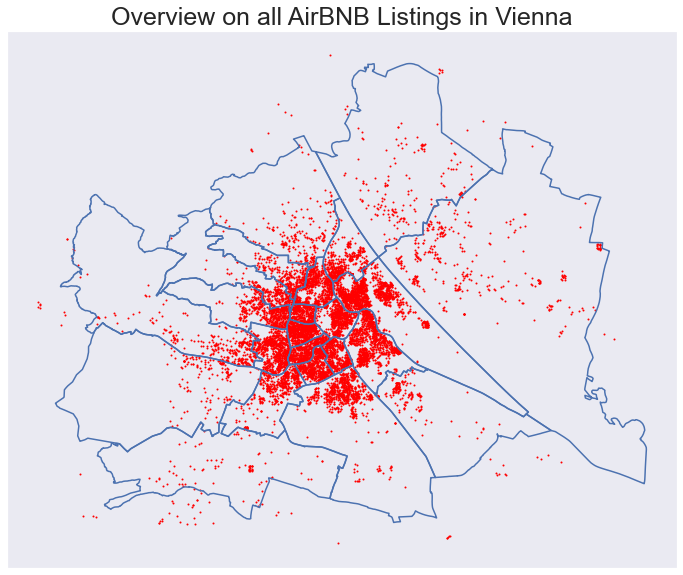

In [4]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title("Overview on all AirBNB Listings in Vienna", fontsize=25)
ax.set_xticks([])
ax.set_yticks([])
grenzen.exterior.plot(ax=ax)
listings.plot(ax=ax, markersize=1, color='red')
fig.savefig(r".\plots\listings_overview.png", dpi=600)

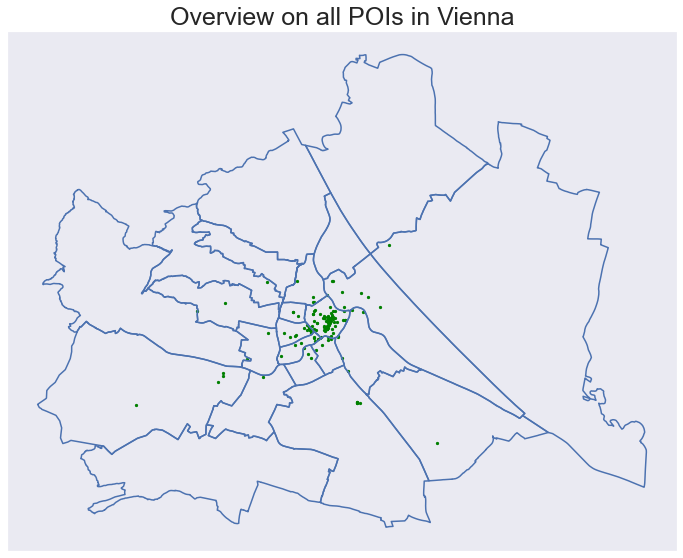

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title("Overview on all POIs in Vienna", fontsize=25)
ax.set_xticks([])
ax.set_yticks([])
grenzen.exterior.plot(ax=ax)
pois.plot(ax=ax, markersize=5, color='green')
fig.savefig(r".\plots\pois_overview.png", dpi=600)

### Kernel Density Estimations
We calculate Kernel Density Estimations on a 200 x 200 grid form the x and y limits of the AirBNB dataset. For each of the 40,000 grid cells a KDE ist calculated for AirBNB and POI data. For that we use the projectied coordinates to have the same distances in x and y direction.

In [6]:
# KDE - AirBNB
# get x and y values
x = listings_rep.geometry.x.values
y = listings_rep.geometry.y.values

# get kde object form xs and ys
kde = gaussian_kde(np.vstack([x, y]))

# set up the grid
xgrid = np.linspace(x.min(), x.max(), 200)
ygrid = np.linspace(y.min(), y.max(), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

# evaluate for each grid
KDE_airbnb = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

In [7]:
# KDE- POIS
# same workflow, but the the x and y values form above for the grid creation, to ensure that the same spot is compared
x_2 = pois_rep.geometry.x.values
y_2 = pois_rep.geometry.y.values

kde = gaussian_kde(np.vstack([x_2, y_2]))
xgrid_2 = np.linspace(x.min(), x.max(), 200)
ygrid_2 = np.linspace(y.min(), y.max(), 200)
Xgrid_2, Ygrid_2 = np.meshgrid(xgrid_2, ygrid_2)
KDE_pois = kde.evaluate(np.vstack([Xgrid_2.ravel(), Ygrid_2.ravel()]))

### KDE Maps
The KDE grids can be plotted as a rastermap, with the color intensity representing the Kernel Density Values.

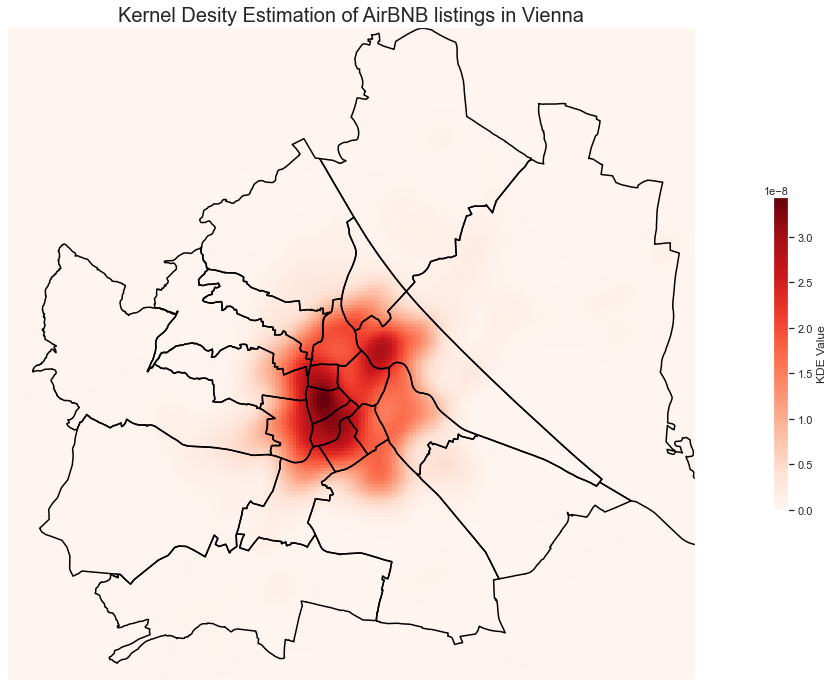

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 12))
ax.set_title('Kernel Desity Estimation of AirBNB listings in Vienna', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
grenzen_rep.exterior.plot(ax=ax, color='black')
plt.imshow(KDE_airbnb.reshape(Xgrid.shape), origin='lower', aspect='auto', extent=[x.min(), x.max(), y.min(), y.max()], cmap='Reds')
plt.colorbar(label='KDE Value',fraction=0.02, pad=0.1, ax=ax)
fig.savefig(r".\plots\KDE_airbnb.png", dpi=600)

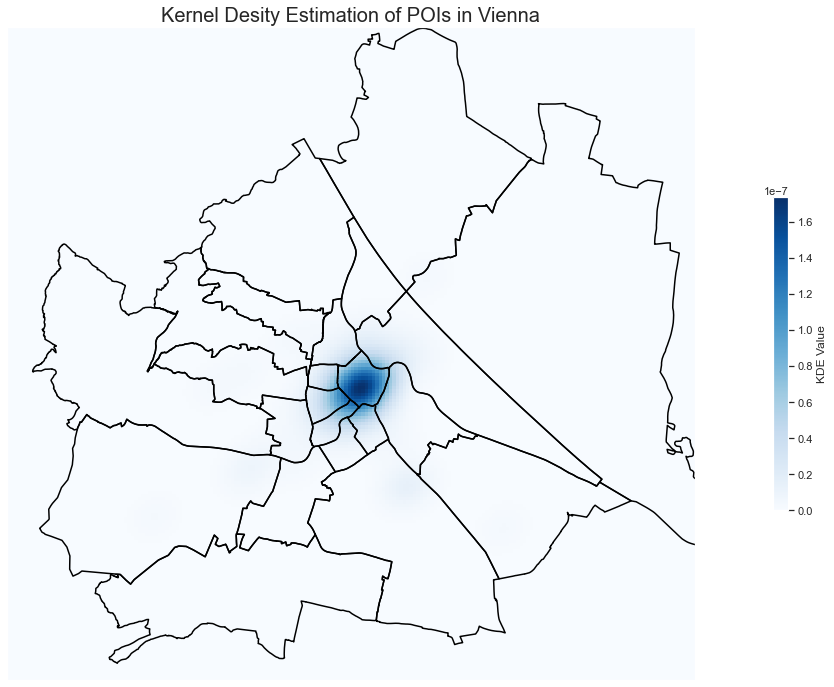

In [9]:
fig, ax = plt.subplots(1, figsize=(14, 12))
ax.set_title('Kernel Desity Estimation of POIs in Vienna', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
grenzen_rep.exterior.plot(ax=ax, color='black')
plt.imshow(KDE_pois.reshape(Xgrid_2.shape), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', cmap='Blues')
plt.colorbar(label='KDE Value',fraction=0.02, pad=0.1, ax=ax)
fig.savefig(r".\plots\KDE_pois.png", dpi=600)

### KDE Scatterplot
We now draw a scatterplot, with the axis representing the KDE values for the AirBNB and POI grid. Each point represents a gridcell and the respecte AirBNB and POI Kernel Density. This allows us to see if how AirBNB and POI density interacts with each other. Furthermore we fit a 4rd degree polynomial fit through the data.

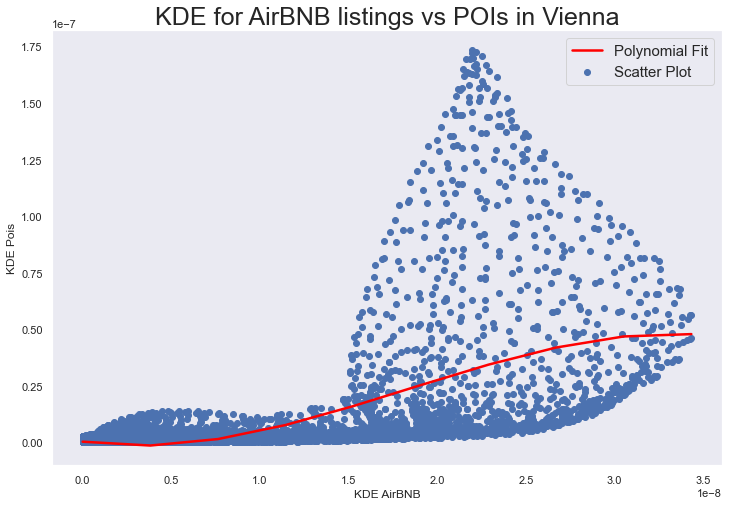

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.set_title('KDE for AirBNB listings vs POIs in Vienna', fontsize=25)

plt.xlabel('KDE AirBNB')
plt.ylabel('KDE Pois')
ax.scatter(KDE_airbnb, KDE_pois, label='Scatter Plot')


p = np.poly1d((np.polyfit(KDE_airbnb, KDE_pois, deg=3)))
xseq = np.linspace(0, max(KDE_airbnb), num=10)
ax.plot(xseq, [p(x) for x in xseq], lw=2.5, color='red', label='Polynomial Fit')
ax.legend(loc='best', fontsize=15)
fig.savefig(r".\plots\scatterplot.png", dpi=600)

- Low POI density where there is low AirBNB density (bottom left)
- POI desity peaks not at AirBNB density peak
- Very High AirBNB density never occures with very low POI density (bottom right)

### DBSCAN
The DBSCAN algorithm is used to identify clusters in our AirBNB listings. First we initialize the DBSCAN algorithm with the Parameters 200 for epsilon and 45 for minPoints. These were chosen by trial and error. We need to take the projected listing data, since we want to give epsilon in meters.

Lables are the extracted.

In [11]:
listings_rep['x'] = listings_rep.geometry.x
listings_rep['y'] = listings_rep.geometry.y
listings_points = listings_rep[['x', 'y']]
clustering = DBSCAN(eps=200, min_samples=45).fit(listings_points)

listings_points["cluster"] = clustering.labels_

C:\Users\Simsi_Arbeit\anaconda3\envs\sds\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### CLuster Plot
The clusters are plotted. 24 clusters are identified. These are found in and around the center and vary in size.

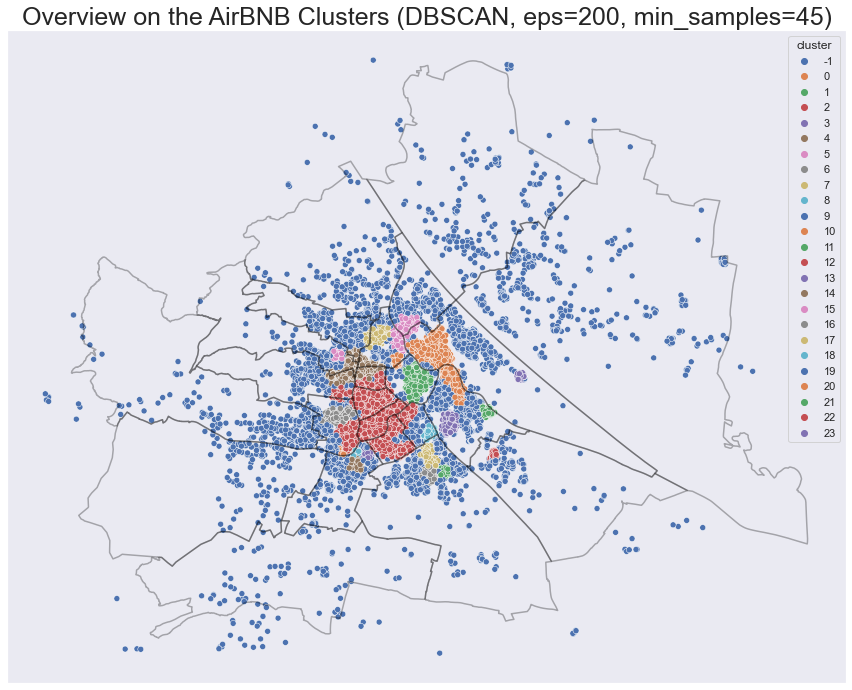

In [12]:
fig, ax = plt.subplots(1, figsize=(16, 12))
ax.set_title("Overview on the AirBNB Clusters (DBSCAN, eps=200, min_samples=45)", fontsize=25)
ax.set_xticks([])
ax.set_yticks([])
grenzen_rep.exterior.plot(color='black', ax=ax, alpha=0.3)
sns.scatterplot(x="x", y="y", hue='cluster', palette="deep", data=listings_points, ax=ax)
fig.savefig(r".\plots\cluster.png", dpi=600)

### Extracting Top 5 Clusters
We than sort the clusters by size and take the five biggest ones (excluding the points that are not part of a cluster).

In [13]:
listings_rep['cluster'] = listings_points['cluster']

grouped = listings_rep.groupby('cluster').size()
grouped = grouped.sort_values(ascending=False)

# Get cluster lables, excluding the -1 group
biggest_clusters = grouped[1:6].index.tolist()

only_biggest_listings = listings_rep[listings_rep['cluster'].isin(biggest_clusters)]

### Convex Hull
For each cluster a Convex Hull is calculated. These are transformed into  shapely Polygon and are put into a new GeoDataFrame.

In [14]:
hulls = {}

for group, data in only_biggest_listings.groupby('cluster'):
    hull =  ConvexHull(data[['x', 'y']], qhull_options='Qt')
    hulls[group] = hull

polys = []
for key, hull in hulls.items():
    group = key

    vertices = hull.points[hull.vertices]

    poly = Polygon(vertices)
    polys.append(poly)
    
polys = gpd.GeoDataFrame(polys, geometry=0).rename(columns={0: 'geometry'})

### Compare with POI Data
We use the five Polygons to get insights about the POIs in their boundries. We define two functions: One that uses a polygon mask to clip the POIs inside a polygon and returns their categories as a list. And one that extracts the most common category inside that list. We lso calculate POIs per Listing, but decided to to put it into the final visualiztion/presentation.

In [15]:
def add_pois(poly):
    clipped = gpd.clip(pois_rep, poly)
    l = clipped['category'].tolist()
    return l

def most_frequent(_list):
    if len(_list) == 0:
        return "No POIS"
    return max(set(_list), key = _list.count)

In [16]:
# apply the add_pois, count the length of the list, get the amount of listings per cluster, calculte the price per listing
# and then apply the most_frequent function
polys['kats'] = polys['geometry'].apply(add_pois)
polys['counts'] = polys['kats'].apply(len)
polys['counts_listings'] = only_biggest_listings.groupby('cluster').size().tolist()
polys['pois_per_listing'] = (polys['counts']*1000/polys['counts_listings']).round(1)
polys['most_common_category'] = polys['kats'].apply(most_frequent)

### Plot the Cluster Map
Now we plot the five clusters in different colors. Then add their most common POI-type as a text. The POIs themselves are also shown for completeness.

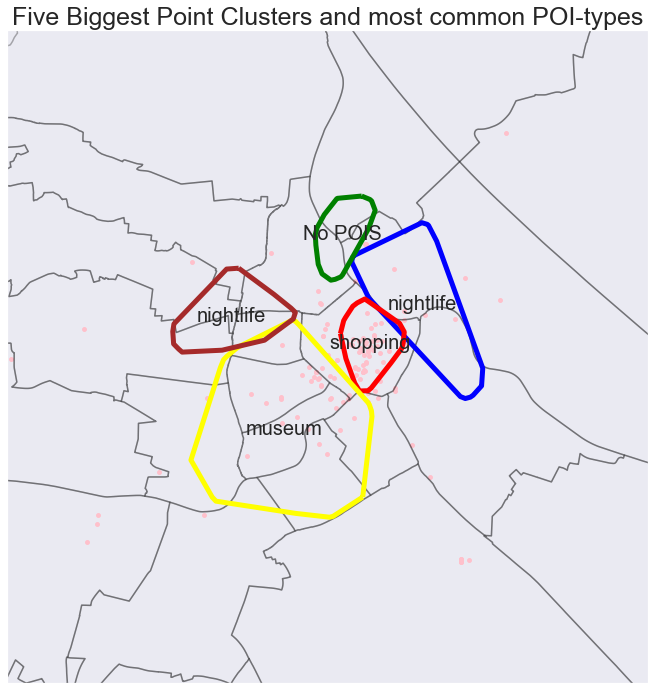

In [17]:
fig, ax = plt.subplots(1, figsize=(12, 12))

ext = polys.geometry.total_bounds
xlim = ([ext[0]-3000,  ext[2]+3000])
ylim = ([ext[1]-3000,  ext[3]+3000])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Five Biggest Point Clusters and most common POI-types", fontsize=25)
grenzen_rep.exterior.plot(color='black', ax=ax, alpha=0.3)

def plot_text(poly):
    x, y = poly['geometry'].centroid.coords[0]
    plt.text(x, y, poly['most_common_category'], fontsize=20, ha='center', va='center')
    
    # Here, POIs per 1000 listings would be added, but that kind of overlods the map in our opinion. Feel free to uncomment :)
    #plt.text(x, y, "\n\nPOIS per 1000 Listings: "+str(poly['pois_per_listing']), fontsize=15, ha='center', va='center')
    
    
polys.exterior.plot(ax=ax, color=['blue', 'red', 'yellow', 'brown', 'green'], linewidth=5)
_ = polys.apply(plot_text, axis=1)

pois_rep.plot(ax=ax, markersize=15, color="pink")

fig.savefig(r".\plots\convexhulls.png", dpi=600)